# Mask Classification

This Notebook contains a model trainable from scratch a model based on VGG16

In [35]:
import os
import numpy as np 
import tensorflow as tf 
import pandas
import random

SEED = 1234

tf.random.set_seed(SEED)



In [95]:
cwd = os.getcwd()
os.chdir('/Users/matteosacco/Drive/PoliMi/1-ANN_DL/LAB/AN2DL-homeworks')
cwd

'/Users/matteosacco/Drive/PoliMi/1-ANN_DL/LAB/AN2DL-homeworks'

In [96]:
# from google.colab import drive
# drive.mount('/content/drive')

In [97]:
def add_noise(img):
    '''Add random noise to an image'''
    VARIABILITY = 25
    deviation = VARIABILITY*random.random()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    np.clip(img, 0., 255.)
    return img

In [123]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

apply_data_augmentation = True

if apply_data_augmentation: #if data augmentation is enabled, create the generator
     train_data_gen = ImageDataGenerator(rotation_range=10,
                                        zoom_range=0.1,
                                        horizontal_flip=True,
                                        vertical_flip=True,
                                        fill_mode='constant',
                                        cval=0,
                                        validation_split = 0.25,
                                        preprocessing_function=add_noise,
                                        rescale=1./255)
else: #rescale only the image
     train_data_gen = ImageDataGenerator(rescale = 1./255, validation_split = 0.3)                                       

#rescale only on validation dataset and test dataset
test_data_gen = ImageDataGenerator(rescale = 1./255)


In [124]:
#width and height of images
img_w = 256
img_h = 256

num_classes = 3

classes = ["NO PERSON", "ALL THE PEOPLE", "SOMEONE"]

bs = 32 #batch size

In [125]:
cwd

'/Users/matteosacco/Drive/PoliMi/1-ANN_DL/LAB/AN2DL-homeworks'

In [126]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#Loading data 
import json 

#setting dirs
# dataset_dir = os.path.join(cwd, "MaskDataset")
# dataset_dir = os.path.join('/Users/matteosacco/Documents/Datasets', "MaskDataset")
#cwd = "/content/drive/My Drive/PoliMi/1-ANN_DL/LAB/AN2DL-homeworks/"
#dataset_dir = os.path.join(cwd, "MaskDataset")
dataset_dir = os.path.join(cwd, "MaskDataset")
training_dir = os.path.join(dataset_dir, "training")
validation_dir = training_dir


#reading json file
with open(os.path.join(dataset_dir,"train_gt.json")) as f:
  dic = json.load(f)


dataframe = pandas.DataFrame(dic.items())

dataframe.rename(columns = {0:'filename', 1:'class'}, inplace = True)

dataframe["class"] = dataframe["class"].astype(str)

train_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               class_mode='categorical',
                                               subset='training',
                                               shuffle=True,
                                               seed=SEED)

valid_gen = train_data_gen.flow_from_dataframe(dataframe,
                                               training_dir,
                                               batch_size=bs,
                                               target_size=(img_h, img_w),
                                               subset='validation',
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=SEED)                                                                                                                                                                                     

Found 3930 validated image filenames belonging to 3 classes.
Found 1684 validated image filenames belonging to 3 classes.


In [91]:
#Creating Dataset objects


train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

train_dataset = train_dataset.repeat()


valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen,
                                               output_types=(tf.float32, tf.float32),
                                               output_shapes=([None, img_h, img_w, 3], [None, num_classes]))

valid_dataset = valid_dataset.repeat()     


In [82]:
# Architecture: Features extraction -> Classifier

model = tf.keras.Sequential()

transfer_learning = True

if transfer_learning:
    # Load VGG16 Model

    vgg = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
    # Create Model
    # ------------

    finetuning = True

    if finetuning:
        freeze_until = 16 # layer from which we want to fine-tune
        
        for layer in vgg.layers[:freeze_until]:
            layer.trainable = False
    else:
        vgg.trainable = False
        
    model.add(vgg)

else:
    #Creating a CNN from scratch
    start_f = 8
    depth = 4

    

    # Features extraction
    for i in range(depth):

        if i == 0:
            input_shape = [img_h, img_w, 3]
        else:
            input_shape=[None]

        # Conv block: Conv2D -> Activation -> Pooling
        model.add(tf.keras.layers.Conv2D(filters=start_f, 
                                        kernel_size=(3, 3),
                                        strides=(1, 1),
                                        padding='same',
                                        input_shape=input_shape))
        model.add(tf.keras.layers.ReLU())
        model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))

        start_f *= 2
    
# Classifier
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(units=512, activation='relu'))
if(transfer_learning == False):
    model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(units=num_classes, activation='softmax'))

In [83]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 8, 8, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               16777728  
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 1539      
Total params: 31,493,955
Trainable params: 21,498,883
Non-trainable params: 9,995,072
_________________________________________________________________


In [84]:
# # Load the model
# load_model = True
# if load_model:
#     latest = tf.train.latest_checkpoint(os.path.join("C:\\Users\\Giovanni\\Desktop\\Università\\Magistrale\\ANN\\AN2DL-homeworks\\image-classification\\classification_experiments\\CNN_Nov12_19-13-43\\ckpts", ""))
#     model.load_weights(latest, by_name=False)

In [85]:
# Optimization params
# -------------------

# Loss
loss = tf.keras.losses.CategoricalCrossentropy()

# learning rate
lr = 1e-5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
# -------------------

# Validation metrics
# ------------------

metrics = ['accuracy']
# ------------------

# Compile Model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [86]:
from datetime import datetime


exps_dir = os.path.join(cwd, 'image-classification') # added
exps_dir = os.path.join(exps_dir, 'classification_experiments')

# exps_dir = os.path.join(cwd, 'classification_experiments')
if not os.path.exists(exps_dir):
    os.makedirs(exps_dir)

now = datetime.now().strftime('%b%d_%H-%M-%S')

model_name = 'CNN'

exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
if not os.path.exists(exp_dir):
    os.makedirs(exp_dir)
    
callbacks = []

# Model checkpoint
# ----------------
ckpt_dir = os.path.join(exp_dir, 'ckpts')
if not os.path.exists(ckpt_dir):
    os.makedirs(ckpt_dir)

ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp_{epoch:02d}.ckpt'), 
                                                   save_weights_only=True)  # False to save the model directly
callbacks.append(ckpt_callback)

# Visualize Learning on Tensorboard
# ---------------------------------
tb_dir = os.path.join(exp_dir, 'tb_logs')
if not os.path.exists(tb_dir):
    os.makedirs(tb_dir)
    
# By default shows losses and metrics for both training and validation
tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir,
                                             profile_batch=0,
                                             histogram_freq=1)  # if 1 shows weights histograms
callbacks.append(tb_callback)

# Early Stopping
# --------------
early_stop = True
if early_stop:
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,restore_best_weights=True )
    callbacks.append(es_callback)

ckpt_dir

'/Users/matteosacco/Drive/PoliMi/1-ANN_DL/LAB/AN2DL-homeworks/image-classification/classification_experiments/CNN_Nov20_20-10-22/ckpts'

In [87]:
import time
import matplotlib.pyplot as plt

%matplotlib inline
    
iterator = iter(train_dataset)



[]

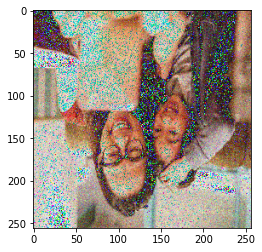

In [88]:
augmented_img, target = next(iterator)
augmented_img = np.array(augmented_img[0]) # First element
augmented_img = augmented_img * 255  # denormalize
   
plt.imshow(np.uint8(augmented_img))
#fig.canvas.draw()
plt.plot()

In [89]:
iterator2 = iter(valid_dataset)
augmented_img, target = next(iterator2)
augmented_img = np.array(augmented_img[0]) # First element
augmented_img = augmented_img * 255  # denormalize
   
plt.imshow(np.uint8(augmented_img))
#fig.canvas.draw()
plt.plot()

InvalidArgumentError: slice index 0 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [31]:
model.fit(x=train_dataset,
          epochs=60,  #### set repeat in training dataset
          steps_per_epoch=len(train_gen),
          validation_data=valid_dataset,
          validation_steps=len(valid_gen), 
          callbacks=callbacks)

Epoch 1/40
176/176 [==============================] - 308s 2s/step - loss: 0.8635 - accuracy: 0.5700 - val_loss: 0.6758 - val_accuracy: 0.6719
Epoch 2/40
176/176 [==============================] - 308s 2s/step - loss: 0.6651 - accuracy: 0.6767 - val_loss: 0.7030 - val_accuracy: 0.6621
Epoch 3/40
176/176 [==============================] - 310s 2s/step - loss: 0.6213 - accuracy: 0.7034 - val_loss: 0.5451 - val_accuracy: 0.7515
Epoch 4/40
176/176 [==============================] - 309s 2s/step - loss: 0.5942 - accuracy: 0.7248 - val_loss: 0.4917 - val_accuracy: 0.7777
Epoch 5/40
176/176 [==============================] - 313s 2s/step - loss: 0.5386 - accuracy: 0.7535 - val_loss: 0.5318 - val_accuracy: 0.7494
Epoch 6/40
176/176 [==============================] - 311s 2s/step - loss: 0.5288 - accuracy: 0.7633 - val_loss: 0.4784 - val_accuracy: 0.7905
Epoch 7/40
176/176 [==============================] - 311s 2s/step - loss: 0.4919 - accuracy: 0.7750 - val_loss: 0.4148 - val_accuracy: 0.8176

In [ ]:
#check that is all ok

#iterator = iter(valid_dataset)



#from PIL import Image

#for i in range(10):
#    sample, target = next(iterator)
#    sample_ = sample[0, ...]

#    img = Image.fromarray(np.uint8(np.array(sample_)*255.))
#    img = img.resize([img_w,img_h])
#    img_array = np.array(img)
#    img_array = np.expand_dims(img_array, 0) 
#    img_array = tf.cast(img_array, tf.float32) / 255.
#    prediction = model.predict(img_array)
#    img
#    print("Predicted:"+classes[np.argmax(prediction)])
#    print("Original:" +classes[tf.argmax(target[0], axis=0)])

#sample_
#class_names[tf.argmax(target[0], axis=0)]

In [ ]:
# Test Dataset 
# Useful if you want to see images with predictions  

#from PIL import Image
#image_filenames = next(os.walk('MaskDataset/test'))[2]

#results = {}
#for image_name in image_filenames:
#   img = Image.open('MaskDataset/test/'+image_name).convert('RGB')
#   img = img.resize((img_w,img_h))
#   img_array = np.array(img)
#   img_array = np.expand_dims(img_array, 0) 
#   img_array = tf.cast(img_array, tf.float32) / 255.
#   prediction = model.predict(img_array)
#   img
#   classes[np.argmax(prediction)]
   


In [ ]:
#Creating CSV

import os
from datetime import datetime
from PIL import Image

def create_csv(results, results_dir='./'):

    csv_fname = 'results_'
    csv_fname += datetime.now().strftime('%b%d_%H-%M-%S') + '.csv'

    with open(os.path.join(results_dir, csv_fname), 'w') as f:

        f.write('Id,Category\n')

        for key, value in results.items():
            f.write(key + ',' + str(value) + '\n')


image_filenames = next(os.walk('MaskDataset/test'))[2]

results = {}
for image_name in image_filenames:
   img = Image.open('MaskDataset/test/'+image_name).convert('RGB')
   img = img.resize((img_w,img_h))
   img_array = np.array(img)
   img_array = np.expand_dims(img_array, 0) 
   img_array = tf.cast(img_array, tf.float32) / 255.
   prediction = model.predict(img_array)
   results[image_name] = np.argmax(prediction)

create_csv(results)            